In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **1. Chuẩn bị dữ liệu**

## **1.1 Tải và đọc dữ liệu**

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import numpy as np

np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

data = np.array(train_dataset.data)
targets = np.array(train_dataset.targets)
classes = train_dataset.classes

print(data.shape)
print(targets.shape)
print(classes)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(50000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


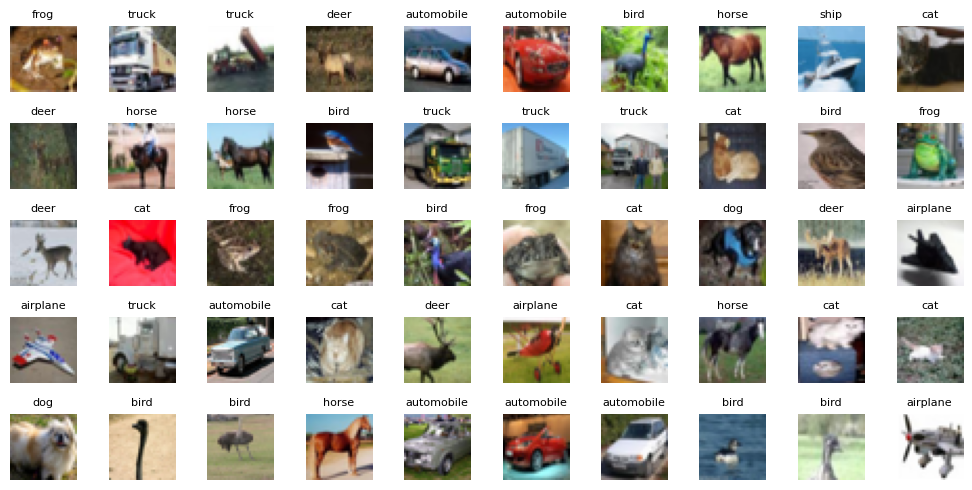

In [3]:
import matplotlib.pyplot as plt

def display_images_grid(data, targets, classes):
    plt.figure(figsize=(10, 5))

    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(data[i])
        label_index = targets[i]
        plt.title(classes[label_index], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images_grid(data, targets, classes)

## **1.2 Chia dữ liệu cho các clients**

In [4]:
def get_non_overlapping_indices(targets, client1_classes, client2_classes, client3_classes):
    client1_indices = []
    client2_indices = []
    client3_indices = []

    # Xử lý các lớp của client 1
    for cls in client1_classes:
        class_indices = np.where(targets == cls)[0]
        if cls == 0:
            split = np.array_split(class_indices, 2)
            client1_indices.append(split[0])
            client3_indices.append(split[1])
        else:
            split = np.array_split(class_indices, 3)
            client1_indices.append(split[0])
            client2_indices.append(split[1])
            client3_indices.append(split[2])

    # Xử lý các lớp chỉ có ở client 2
    for cls in client2_classes:
        if cls not in client1_classes:
            class_indices = np.where(targets == cls)[0]
            split = np.array_split(class_indices, 2)
            client2_indices.append(split[0])
            client3_indices.append(split[1])

    # Xử lý các lớp chỉ có ở client 3
    for cls in client3_classes:
        if cls not in client1_classes and cls not in client2_classes:
            class_indices = np.where(targets == cls)[0]
            client3_indices.append(class_indices)

    # Gộp lại thành danh sách chỉ số
    client1_indices = np.concatenate(client1_indices)
    client2_indices = np.concatenate(client2_indices)
    client3_indices = np.concatenate(client3_indices)

    return client1_indices, client2_indices, client3_indices

client1_classes = [0, 1, 2, 3, 4]  # máy bay, ô tô, chim, mèo, hươu
client2_classes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # ô tô, chim, mèo, hươu, chó, ếch, ngựa, tàu và xe tải
client3_classes = list(range(10))  # tất cả các lớp

client1_indices, client2_indices, client3_indices = get_non_overlapping_indices(targets, client1_classes, client2_classes, client3_classes)

client1_dataset = torch.utils.data.Subset(train_dataset, client1_indices)
client2_dataset = torch.utils.data.Subset(train_dataset, client2_indices)
client3_dataset = torch.utils.data.Subset(train_dataset, client3_indices)

In [5]:
print(f"Client 1 dataset size: {len(client1_dataset)}")
print(f"Client 2 dataset size: {len(client2_dataset)}")
print(f"Client 3 dataset size: {len(client3_dataset)}")

Client 1 dataset size: 9168
Client 2 dataset size: 19168
Client 3 dataset size: 21664


Client 1 class count: Counter({0: 2500, 1: 1667, 2: 1667, 3: 1667, 4: 1667})
Client 2 class count: Counter({5: 2500, 6: 2500, 7: 2500, 8: 2500, 9: 2500, 1: 1667, 2: 1667, 3: 1667, 4: 1667})
Client 3 class count: Counter({0: 2500, 5: 2500, 6: 2500, 7: 2500, 8: 2500, 9: 2500, 1: 1666, 2: 1666, 3: 1666, 4: 1666})


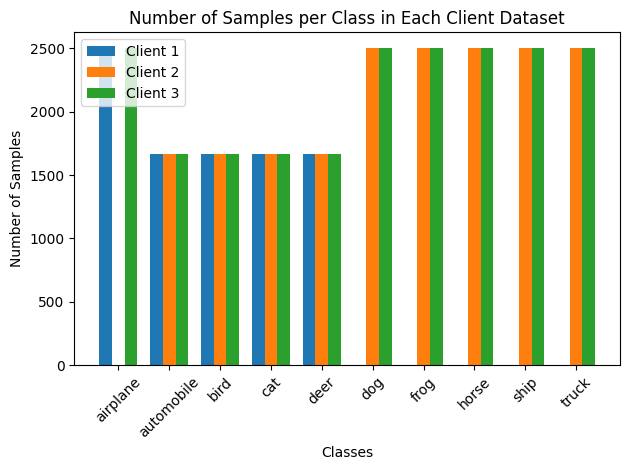

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Lấy nhãn của từng dataset
client1_labels = np.array([train_dataset.targets[idx] for idx in client1_dataset.indices])
client2_labels = np.array([train_dataset.targets[idx] for idx in client2_dataset.indices])
client3_labels = np.array([train_dataset.targets[idx] for idx in client3_dataset.indices])

# Đếm số lượng mẫu của mỗi class
client1_class_count = Counter(client1_labels)
client2_class_count = Counter(client2_labels)
client3_class_count = Counter(client3_labels)

# In ra số lượng mẫu cho từng class của từng client (tùy chọn)
print("Client 1 class count:", client1_class_count)
print("Client 2 class count:", client2_class_count)
print("Client 3 class count:", client3_class_count)

# Thiết lập các lớp (class labels)
x = np.arange(len(classes))

# Tạo danh sách số lượng mẫu cho từng lớp (các giá trị này dựa trên Counter)
client1_counts = [client1_class_count.get(i, 0) for i in range(10)]
client2_counts = [client2_class_count.get(i, 0) for i in range(10)]
client3_counts = [client3_class_count.get(i, 0) for i in range(10)]

# Vẽ biểu đồ thanh cho mỗi client
width = 0.25  # Độ rộng của mỗi thanh

fig, ax = plt.subplots()
ax.bar(x - width, client1_counts, width, label='Client 1')
ax.bar(x, client2_counts, width, label='Client 2')
ax.bar(x + width, client3_counts, width, label='Client 3')

# Đặt tên cho các trục và biểu đồ
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples per Class in Each Client Dataset')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Hiển thị biểu đồ
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **1.3 Chia tập train và tập val**

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch.utils.data import Subset

def split_train_val(dataset, targets, train_size=0.8, random_state=42):
    strat_split = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)

    for train_idx, val_idx in strat_split.split(np.zeros(len(targets)), targets):
        train_set = Subset(dataset, train_idx)
        val_set = Subset(dataset, val_idx)

    return train_set, val_set

# Client 1
client1_targets = np.array([train_dataset.targets[idx] for idx in client1_dataset.indices])
client1_train, client1_val = split_train_val(client1_dataset, client1_targets)

# Client 2
client2_targets = np.array([train_dataset.targets[idx] for idx in client2_dataset.indices])
client2_train, client2_val = split_train_val(client2_dataset, client2_targets)

# Client 3
client3_targets = np.array([train_dataset.targets[idx] for idx in client3_dataset.indices])
client3_train, client3_val = split_train_val(client3_dataset, client3_targets)

print(f"Client 1: Train samples = {len(client1_train)}, Val samples = {len(client1_val)}")
print(f"Client 2: Train samples = {len(client2_train)}, Val samples = {len(client2_val)}")
print(f"Client 3: Train samples = {len(client3_train)}, Val samples = {len(client3_val)}")

Client 1: Train samples = 7334, Val samples = 1834
Client 2: Train samples = 15334, Val samples = 3834
Client 3: Train samples = 17331, Val samples = 4333


# **2. Tiền xử lý dữ liệu**

## **2.1 Trích xuất đặc trưng HOG**

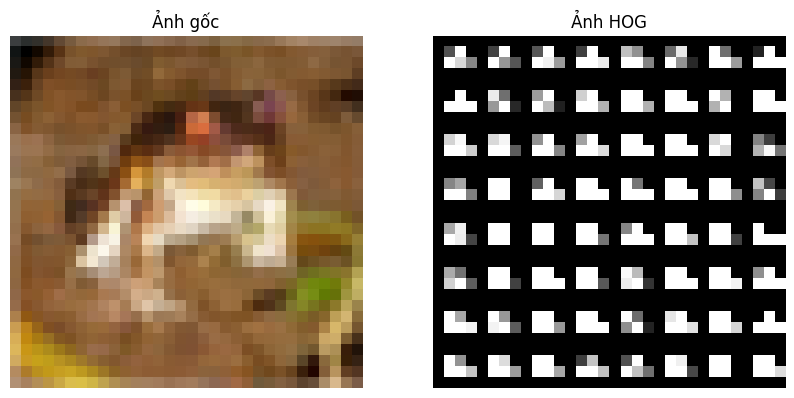

In [8]:
from skimage.feature import hog
from skimage import data, color, exposure
import matplotlib.pyplot as plt
import numpy as np

image = client1_dataset.dataset.data[0]

fd, hog_image = hog(image,
                    orientations=9,
                    pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=True,
                    channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Ảnh gốc')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Ảnh HOG')

plt.show()

In [9]:
from skimage.feature import hog
import numpy as np

def extract_hog_features(image):
    image = image.numpy()
    image = image.transpose(1, 2, 0)
    hog_feature = hog(image,
                      orientations=9,
                      pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      feature_vector=True,
                      channel_axis=2)
    return hog_feature

def extract_hog_for_dataset(dataset):
    hog_features_list = [extract_hog_features(image) for image, _ in dataset]
    labels_list = [label for _, label in dataset]

    return np.array(hog_features_list), np.array(labels_list)


# Trích xuất HOG cho Client 1
client1_train_hog, client1_train_labels = extract_hog_for_dataset(client1_train)
client1_val_hog, client1_val_labels = extract_hog_for_dataset(client1_val)

# Trích xuất HOG cho Client 2
client2_train_hog, client2_train_labels = extract_hog_for_dataset(client2_train)
client2_val_hog, client2_val_labels = extract_hog_for_dataset(client2_val)

# Trích xuất HOG cho Client 3
client3_train_hog, client3_train_labels = extract_hog_for_dataset(client3_train)
client3_val_hog, client3_val_labels = extract_hog_for_dataset(client3_val)


In [10]:
client1_train_hog.shape, client1_val_hog.shape

((7334, 1764), (1834, 1764))

In [11]:
client2_train_hog.shape, client2_val_hog.shape

((15334, 1764), (3834, 1764))

In [12]:
client3_train_hog.shape, client3_train_labels.shape

((17331, 1764), (17331,))

## **2.2 Giảm chiều vector đặc trưng**

In [13]:
!pip install umap-learn

In [14]:
import umap

def reduce_dim(features, n_components=50):
    reducer = umap.UMAP(n_components=n_components)
    reduced_features = reducer.fit_transform(features)

    return reduced_features

In [15]:
# Giảm chiều cho Client 1
X_train_128d_client1 = reduce_dim(client1_train_hog, n_components=128)
X_val_128d_client1 = reduce_dim(client1_val_hog, n_components=128)

X_train_256d_client1 = reduce_dim(client1_train_hog, n_components=256)
X_val_256d_client1 = reduce_dim(client1_val_hog, n_components=256)

In [16]:
# Giảm chiều cho Client 2
X_train_128d_client2 = reduce_dim(client2_train_hog, n_components=128)
X_val_128d_client2 = reduce_dim(client2_val_hog, n_components=128)

X_train_256d_client2 = reduce_dim(client2_train_hog, n_components=256)
X_val_256d_client2 = reduce_dim(client2_val_hog, n_components=256)

In [17]:
# Giảm chiều cho Client 3
X_train_128d_client3 = reduce_dim(client3_train_hog, n_components=128)
X_val_128d_client3 = reduce_dim(client3_val_hog, n_components=128)

X_train_256d_client3 = reduce_dim(client3_train_hog, n_components=256)
X_val_256d_client3 = reduce_dim(client3_val_hog, n_components=256)

In [18]:
X_train_128d_client1.shape, X_val_128d_client1.shape

((7334, 128), (1834, 128))

In [19]:
from joblib import dump

In [20]:
dump(X_train_128d_client1, 'X_train_128d_client1.joblib')
dump(X_val_128d_client1, 'X_val_128d_client1.joblib')
dump(X_train_256d_client1, 'X_train_256d_client1.joblib')
dump(X_val_256d_client1, 'X_val_256d_client1.joblib')

['X_val_256d_client1.joblib']

In [21]:
dump(X_train_128d_client2, 'X_train_128d_client2.joblib')
dump(X_val_128d_client2, 'X_val_128d_client2.joblib')
dump(X_train_256d_client2, 'X_train_256d_client2.joblib')
dump(X_val_256d_client2, 'X_val_256d_client2.joblib')

['X_val_256d_client2.joblib']

In [22]:
dump(X_train_128d_client3, 'X_train_128d_client3.joblib')
dump(X_val_128d_client3, 'X_val_128d_client3.joblib')
dump(X_train_256d_client3, 'X_train_256d_client3.joblib')
dump(X_val_256d_client3, 'X_val_256d_client3.joblib')

['X_val_256d_client3.joblib']